In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from get_image_dataset import get_dataloader, get_label
from PIL import Image
from torchvision import transforms as T
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
train, test = get_dataloader('normalized_red_quantized')

In [3]:
class ClusteringLayer(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.n_classes = n_classes 
        self.alpha = 1.0
        self.weights = nn.Parameter(torch.randn((self.n_classes, self.n_classes)))
    def forward(self,x):
        assert x.shape[1] == self.n_classes
        q = 1.0 / (1.0 + torch.sqrt(torch.sum(torch.square(torch.unsqueeze(x, 1) - self.weights), dim=2)) ** 2 / self.alpha)
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = torch.transpose(torch.transpose(q,0,1)/torch.sum(q,dim=1),0,1)
        return q

In [4]:
class SSLDEC(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(32,32,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(32,32,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
            )
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(64,64,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(64,64,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(128,64,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(64,32,(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
        )
        self.dense = nn.Sequential(
            nn.Linear(288, 128),
            nn.ELU(),
            nn.Linear(128,6),
            nn.ELU()
        )
        self.clustering = ClusteringLayer(6)
        self.to(self.device)
    def forward(self, x):
        x = self.conv3(self.pool(self.conv2(self.pool(self.conv1(x)))))
        x = torch.flatten(x, 1)
        x = self.dense(x)
        x = self.clustering(x)
        return x

In [5]:
model = SSLDEC()
print(model(torch.randn((1,3,12,12)).to(model.device)))

tensor([[0.1549, 0.1091, 0.2691, 0.1239, 0.2391, 0.1038]], device='mps:0',
       grad_fn=<TransposeBackward0>)


In [54]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        
        for batch in dataloader:
            # batch should contain single image and mask
            image, mask = batch
            # transpose bc images were opened in PIL Image format and converted to np array
            image = torch.transpose(image, 1,3)
            mask = torch.transpose(mask, 1, 3)
            # patch size based on greatest common factor between dimensions, kept square for simplicity
            patch_size = 12
            height = image.shape[0]
            width = image.shape[1]

            for i in range(0, width, patch_size):
                for j in range(0, height, patch_size):
                    box = (i, j, i + patch_size, j + patch_size)
                    # crop out patch from image and mask
                    img_patch = T.functional.crop(image, box[0], box[1], box[2], box[3])
                    mask_patch = T.functional.crop(mask, box[0], box[1], box[2], box[3])

                    # get the label of the patch based on dominant class in patch
                    label = get_label(mask_patch)
                    label_tensor = torch.tensor(label).to(model.device).to(torch.int64)
                    label_dist = nn.functional.softmax(nn.functional.one_hot(label_tensor, num_classes=6).to(torch.float32))
                    img_patch = img_patch.to(model.device).to(torch.float32)
                    outputs = model(img_patch)
                    outputs = nn.functional.log_softmax(outputs)
                    # print(outputs)
                    # print(label_dist)
                    loss = criterion(outputs, label_dist)
                    
                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()
        running_loss /= len(dataloader)
        train_losses.append(running_loss)

        # show graph of loss
        clear_output(wait=True)
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.title("Training Loss Over Epochs")
        plt.show()
    

In [44]:
nn.functional.softmax(nn.functional.one_hot(torch.tensor(1), num_classes=6).to(torch.float32))

/var/folders/08/551bq3_17bqcdv104sd7yclm0000gn/T/ipykernel_93286/157221512.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.functional.softmax(nn.functional.one_hot(torch.tensor(1), num_classes=6).to(torch.float32))


tensor([0.1296, 0.3522, 0.1296, 0.1296, 0.1296, 0.1296])

In [65]:
model = SSLDEC()
loss_func = nn.KLDivLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1*(10**-4), weight_decay=1e-5)

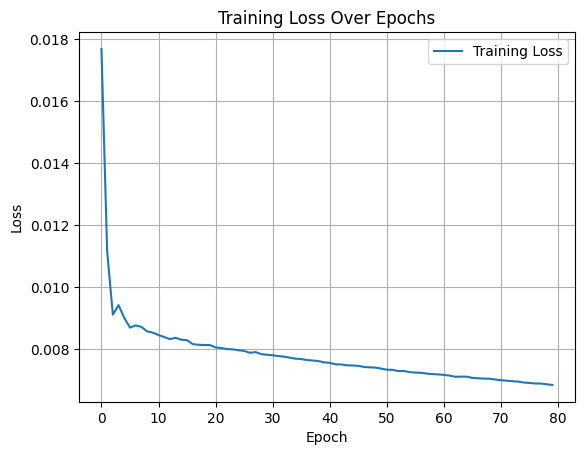

100%|██████████| 80/80 [00:59<00:00,  1.34it/s]


In [66]:
train_model(model, train, loss_func, optimizer, num_epochs=80)

In [59]:
def evaluate_model(model, testloader):
    model.eval()
    count = 0.0
    total = 0.0
    for batch in testloader:
        image, mask = batch
        image = torch.transpose(image, 1,3)
        mask = torch.transpose(mask, 1, 3)
        # patch size based on greatest common factor between dimensions, kept square for simplicity
        patch_size = 12
        height = image.shape[0]
        width = image.shape[1]
        for i in range(0, width, patch_size):
            for j in range(0, height, patch_size):
                box = (i, j, i + patch_size, j + patch_size)
                # crop out patch from image and mask
                img_patch = T.functional.crop(image, box[0], box[1], box[2], box[3])
                mask_patch = T.functional.crop(mask, box[0], box[1], box[2], box[3])

                # get the label of the patch based on dominant class in patch
                label = get_label(mask_patch)
                label_tensor = torch.tensor(label).to(model.device)
                img_patch = img_patch.to(model.device).to(torch.float32)
                outputs = model(img_patch)
                pred = torch.argmax(outputs)
                if pred == label_tensor:
                    count += 1
                total += 1
    print(f'Accuracy: {count / total}')

In [67]:
evaluate_model(model, test)

Accuracy: 0.625


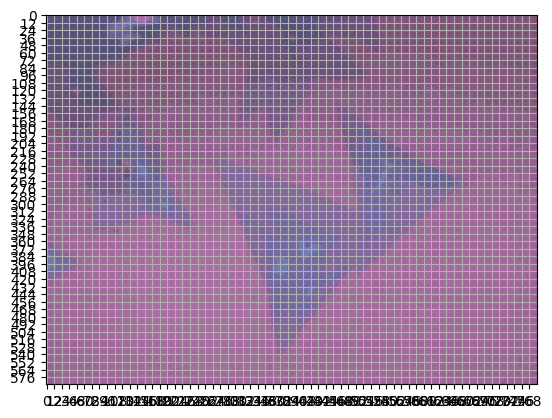

In [9]:
def patch_image(file_path, patch_size):
    width, height = patch_size
    img = Image.open(file_path)
    plt.imshow(img)
    plt.xticks([i for i in range(0,img.size[0], width)])
    plt.yticks([i for i in range(0,img.size[1], height)])
    plt.grid()
    plt.show()
patch_image('../Image Segmentation Data/denoised_quantized/4_MoS2_4.jpg',(12,12))

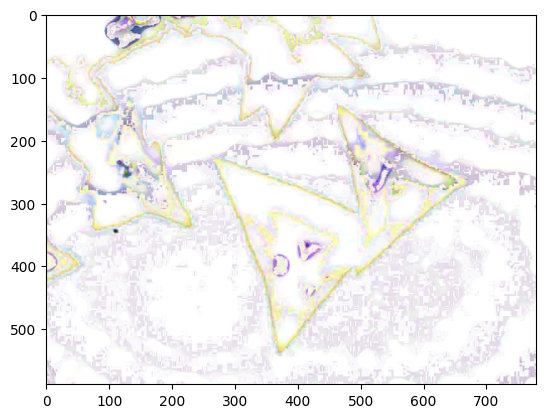

In [10]:
import cv2

img = cv2.imread('../Image Segmentation Data/denoised_quantized/4_MoS2_4.jpg', -1)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.imshow(result_norm)
plt.show()